## Vogelschwarm

### 3D Darstellung zu verschiedenen Zeitpunkten

Einfacher Schwarm ohne Jäger

![](images/giphy.gif)

### Aufgaben - Tasks
- Starten Sie die Simulation mit CTRL-Taste und Enter (gleichzeitig beide Tasten drücken).
- Was zeigen die berechneten 3D Grafiken?
- Ändern Sie den Parameter ```NumberOfBoids ``` auf den Wert 80 und auf den Wert 10.


In [ ]:
%pylab inline
import numpy as np
import time
import sys
import math
 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
 
#################
# Runtime parameters
NumberOfBoids       = 30
Dimensions          = 3
MinSeparation       = 7
 
# Boids behavior - weight on rules
WeightCenterOfMass  = 0.03
WeightSeparation    = 1
WeightAlignment     = 0.125
WeightRandom        = 0.0
WeightCenter        = 0.02 #0.03
 
MaxVelocity         = 1
center              = 50*np.ones(Dimensions)
###########
 
class boid:
    """This class defines the boid and the rules of behavoir"""
    def __init__(self, dimension, index):
        self.index  = index
        self.dim    = dimension
        self.pos    = np.random.uniform(0,100,self.dim)
        self.vel    = np.zeros(self.dim)
        self.size   = np.random.rand(1)
 
    def limitvelocity(self,maxvel):
        """Limiting the speed to avoid unphysical jerks in motion"""
        if np.linalg.norm(self.vel) > maxvel:
            self.vel = (self.vel/np.linalg.norm(self.vel))*maxvel

def normalize(vector):
    """Normalizes a vector"""
    vector = vector/np.linalg.norm(vector)
    return vector
 
def centerofpos(flock):
    """Calculates the 'center of mass' for the flock of boids"""
    com = np.zeros(Dimensions)   
    for dim in range(Dimensions):
        for boid in flock:
            com[dim] = com[dim] + boid.pos[dim]
        com[dim] = com[dim]/len(flock)
    return com
 
def centerofvel(flock):
    """Calculates the mean velocity vector for the flock of boids"""
    cov = np.zeros(Dimensions)   
    for dim in range(Dimensions):
        for boid in flock:
            cov[dim] = cov[dim] + boid.vel[dim]
        cov[dim] = cov[dim]/len(flock)
    return cov
 
def plot_raw(a,b,c):
    """Sets up the basic plotting paramaters"""
    global ax
    ax = fig.add_subplot(a,b,c, projection='3d')
    ax.set_autoscale_on(False)
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.set_xlim3d([0.0, 100.0])
    ax.set_ylim3d([0.0, 100.0])
    ax.set_zlim3d([0.0, 100.0])

def plot_init():
    """The initial draw"""
    #plot_raw(221)
    com = centerofpos(flock)
    boidpos = np.zeros((NumberOfBoids, Dimensions))
    #predpos = np.zeros((NumberOfPredators, Dimensions))
 
    for index,boid in enumerate(flock):
        boidpos[index]= boid.pos       
    bx = boidpos[:,0]
    by = boidpos[:,1]
    bz = boidpos[:,2] 

def plot_update(timestep):
    """ This plot updates the plot with the new positions of the boids
    and predators"""
 
    # 4 Zeitschritte berechnen
    for i in range(4):
        mainloop(timestep)
 
    # Plots the boids in space using matplotlib
    # http://matplotlib.org/examples/mplot3d/scatter3d_demo.html         
    boidpos = np.zeros((NumberOfBoids, Dimensions))
    #predpos = np.zeros((NumberOfPredators, Dimensions))
 
    # Plot center of mass as a black dot
    com = centerofpos(flock)
    ax.scatter(com[0], com[1], com[2], color='black')
 
    # Plot boids as blue dots     
    for index,boid in enumerate(flock):
        boidpos[index]= boid.pos       
    bx = boidpos[:,0]
    by = boidpos[:,1]
    bz = boidpos[:,2] 
    ax.scatter(bx, by, bz, c='b')
   
 
def mainloop(timestep):
    """This is the calculation timeloop"""
    #print "Timestep "+str(timestep)
 
    for boid in flock:
 
        # Boid RULE 1. Cohesion - Steer to move towoards the center of mass
        rule1 = np.zeros(Dimensions)
        rule1 = (centerofpos(flock) - boid.pos)*WeightCenterOfMass
 
        # Boid RULE RULE 2. Separation - steer to avoid crowding local flockmates
        rule2 = np.zeros(Dimensions)
        for boid2 in flock:
            difference  = boid2.pos - boid.pos
            distance    = np.linalg.norm(difference)
            if distance < MinSeparation and boid2 != boid:
                rule2 = rule2 - normalize(difference)/distance
        rule2 = rule2*WeightSeparation 
 
        # Boid RULE 3. Alignment - Steer towards the average heading of local flockmates
        rule3 = np.zeros(Dimensions)
        rule3 = (centerofvel(flock) - boid.vel)*WeightAlignment

        # Move the boids
        boid.vel = rule1 + rule2 + rule3 #+ rule4 + rule5 + rule6
        boid.limitvelocity(MaxVelocity)
        boid.pos = boid.pos + boid.vel
        
 
#Generate the the flock of boids
flock           = [boid(Dimensions,count) for count in range(NumberOfBoids)]
 
# Define the figure:
fig = plt.figure(figsize=(12,30))

# Anzahl Plots
n = 8

for i in range(n):
    plot_raw(n,2,i*2+1)
    plot_update(i)
    
    plot_raw(n,2,(i+1)*2)
    plot_update(i)
 


## Vogelschwarm

### Animation erstellen

Einfacher Schwarm ohne Jäger


### Aufgaben - Tasks
- Starten Sie die folgende Simulation mit CTRL-Taste und Enter. (Berechnungsdauer ca. 30 Sekunden).
- Ändern Sie den Parameter ```timesteps``` auf 120. Wie verhält sich der Schwarm?


In [ ]:

import numpy as np
import time
import sys
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D
 
 
#################
# Runtime parameters
NumberOfBoids       = 45
Dimensions          = 3
MinSeparation       = 7
framespersecond     = 10
timesteps           = 40 #Should be divisible by framespersecond
 
 
# Boids behavior - weight on rules
WeightCenterOfMass  = 0.03
WeightSeparation    = 1
WeightAlignment     = 0.125
WeightRandom        = 0.0
WeightAvoidPredator = 1
WeightCenter        = 0.02 #0.03
 
MaxVelocityP        = 1
MaxVelocity         = 1
center              = 10*np.ones(Dimensions)
###########
 
class boid:
    """This class defines the boid and the rules of behavoir"""
    def __init__(self, dimension, index):
        self.index  = index
        self.dim    = dimension
        self.pos    = np.random.uniform(0,100,self.dim)
        self.vel    = np.zeros(self.dim)
        self.size   = np.random.rand(1)
 
    def limitvelocity(self,maxvel):
        """Limiting the speed to avoid unphysical jerks in motion"""
        if np.linalg.norm(self.vel) > maxvel:
            self.vel = (self.vel/np.linalg.norm(self.vel))*maxvel

def normalize(vector):
    """Normalizes a vector"""
    vector = vector/np.linalg.norm(vector)
    return vector
 
def centerofpos(flock):
    """Calculates the 'center of mass' for the flock of boids"""
    com = np.zeros(Dimensions)   
    for dim in range(Dimensions):
        for boid in flock:
            com[dim] = com[dim] + boid.pos[dim]
        com[dim] = com[dim]/len(flock)
    return com
 
def centerofvel(flock):
    """Calculates the mean velocity vector for the flock of boids"""
    cov = np.zeros(Dimensions)   
    for dim in range(Dimensions):
        for boid in flock:
            cov[dim] = cov[dim] + boid.vel[dim]
        cov[dim] = cov[dim]/len(flock)
    return cov

def mainloop(timestep):
    """This is the calculation timeloop"""
    for boid in flock:
        # Boid RULE 1. Cohesion - Steer to move towoards the center of mass
        rule1 = np.zeros(Dimensions)
        rule1 = (centerofpos(flock) - boid.pos)*WeightCenterOfMass
 
        # Boid RULE RULE 2. Separation - steer to avoid crowding local flockmates
        rule2 = np.zeros(Dimensions)
        for boid2 in flock:
            difference  = boid2.pos - boid.pos
            distance    = np.linalg.norm(difference)
            if distance < MinSeparation and boid2 != boid:
                rule2 = rule2 - normalize(difference)/distance
        rule2 = rule2*WeightSeparation 
 
        # Boid RULE 3. Alignment - Steer towards the average heading of local flockmates
        rule3 = np.zeros(Dimensions)
        rule3 = (centerofvel(flock) - boid.vel)*WeightAlignment
 
 
        # The following rules are custom rules just added for fun. 
        # Boid RULE 4. Try to move towards the center of the grid
        #rule4 = (center - boid.pos)*WeightCenter
 
        # Boid RULE 5. Add some randomness
        #rule5 = np.random.uniform(-1,1,Dimensions)*WeightRandom
 

        # Move the boids
        boid.vel = rule1 + rule2 + rule3 #+ rule4 + rule5 + rule6
        boid.limitvelocity(MaxVelocity)
        boid.pos = boid.pos + boid.vel
        
#Visual Output
        
# Generate the the flock of boids
flock  = [boid(Dimensions,count) for count in range(NumberOfBoids)]
 

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.set_autoscale_on(False)
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_xlim3d([20.0, 80.0])
ax.set_ylim3d([20.0, 80.0])
ax.set_zlim3d([20.0, 80.0])
boidpos = np.zeros((NumberOfBoids, Dimensions))
for index,boid in enumerate(flock):
    boidpos[index]= boid.pos       

bx = boidpos[:,0]
by = boidpos[:,1]
bz = boidpos[:,2] 
dots = ax.scatter(bx, by, bz, c='b')


# define Animation Sequence
def animate(timestep):
    """ This plot updates the plot with the new positions of the boids
    and predators"""
    
    mainloop(timestep)      
    boidpos = np.zeros((NumberOfBoids, Dimensions))
    com = centerofpos(flock)
    ax.scatter(com[0], com[1], com[2], color='black')
 
    # Plot boids as blue dots     
    for index,boid in enumerate(flock):
        boidpos[index]= boid.pos       
    
    bx = boidpos[:,0]
    by = boidpos[:,1]
    bz = boidpos[:,2]
    dots._offsets3d = (bx, by, bz)
    return (dots,)


# Number of Timesteps
timesteps = 20
anim = animation.FuncAnimation(fig, animate,
                              timesteps, interval=40, blit=True)

HTML(anim.to_html5_video())

## Schwarmverhalten mit Jäger


![](images/giphy.gif)
### Aufgaben - Tasks
- Starten Sie die folgende Simulation mit CTRL-Taste und Enter. (Berechnungsdauer ca. 30 Sekunden).
- Ändern Sie den Parameter ```NumberOfPredators``` auf 5. Wie verhält sich der Schwarm?
- Ändern Sie einen der folgenden Parameter und beobachten Sie das Verhalten des Schwarms.
    - ```timesteps``` 
    - ```PredatorSight```
    - ```WeightAvoidPredator```
    - ```WeightAlignment```
    
- Ändern Sie die Simulation, dass eine der Regeln (4,5 oder 6) nicht mehr verwendet wird. Wie verhält sich das System?




In [ ]:
import numpy as np
import time
import sys
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D
 
#################
# Runtime parameters
NumberOfBoids       = 100
NumberOfPredators   = 2
Dimensions          = 3
MinSeparation       = 7
framespersecond     = 24
timesteps           = 60 #Should be divisible by framespersecond
 
# Predator settings
PredatorRadius      = 18
PredatorSight       = 10
WeightCenterOfMassP = 0.00
WeightAttackBoid    = 0 #2
WeightRandomP       = 0.5 #1
WeightKnot          = 2
 
# Boids behavior - weight on rules
WeightCenterOfMass  = 0.03
WeightSeparation    = 1
WeightAlignment     = 0.125
WeightRandom        = 0.0
WeightAvoidPredator = 1
WeightCenter        = 0.02 #0.03
 
MaxVelocityP        = 1
MaxVelocity         = 1
center              = 50*np.ones(Dimensions)
###########
 
class boid:
    """This class defines the boid and the rules of behavoir"""
    def __init__(self, dimension, index):
        self.index  = index
        self.dim    = dimension
        self.pos    = np.random.uniform(0,100,self.dim)
        self.vel    = np.zeros(self.dim)
        self.size   = np.random.rand(1)
 
    def limitvelocity(self,maxvel):
        """Limiting the speed to avoid unphysical jerks in motion"""
        if np.linalg.norm(self.vel) > maxvel:
            self.vel = (self.vel/np.linalg.norm(self.vel))*maxvel

def normalize(vector):
    """Normalizes a vector"""
    vector = vector/np.linalg.norm(vector)
    return vector


def centerofpos(flock):
    """Calculates the 'center of mass' for the flock of boids"""
    com = np.zeros(Dimensions)   
    for dim in range(Dimensions):
        for boid in flock:
            com[dim] = com[dim] + boid.pos[dim]
        com[dim] = com[dim]/len(flock)
    return com

def centerofvel(flock):
    """Calculates the mean velocity vector for the flock of boids"""
    cov = np.zeros(Dimensions)   
    for dim in range(Dimensions):
        for boid in flock:
            cov[dim] = cov[dim] + boid.vel[dim]
        cov[dim] = cov[dim]/len(flock)
    return cov
 
def plot_raw():
    """Sets up the basic plotting paramaters"""
    global ax
    ax = fig.add_subplot(111, projection='3d')
    ax.set_autoscale_on(False)
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.set_xlim3d([20.0, 80.0])
    ax.set_ylim3d([20.0, 80.0])
    ax.set_zlim3d([20.0, 80.0])

def plot_init():
    """The initial draw"""

def plot_update(timestep):
    """ This plot updates the plot with the new positions of the boids
    and predators"""
    fig.clf()
    plot_raw()
 
    # Execute a calculation of the next set of moves
    mainloop(timestep)
 
    # Plots the boids in space using matplotlib
    # http://matplotlib.org/examples/mplot3d/scatter3d_demo.html         
    boidpos = np.zeros((NumberOfBoids, Dimensions))
    predpos = np.zeros((NumberOfPredators, Dimensions))
 
    # Plot center of mass as a black dot
    com = centerofpos(flock)
    ax.scatter(com[0], com[1], com[2], color='black')
 
    # Plot boids as blue dots     
    for index,boid in enumerate(flock):
        boidpos[index]= boid.pos       
    bx = boidpos[:,0]
    by = boidpos[:,1]
    bz = boidpos[:,2] 
    ax.scatter(bx, by, bz, c='b')
 
    # Predators are red dots
    if len(predators) > 0:
        for index,predator in enumerate(predators):
            predpos[index]= predator.pos       
        px = predpos[:,0]
        py = predpos[:,1]
        pz = predpos[:,2] 
        ax.scatter(px, py, pz, s=100,color='red')      

def mainloop(timestep):
    """This is the calculation timeloop"""
    # print "Timestep "+str(timestep)
 
    if len(predators) > 0:
        for predator in predators:
 
            # Predator RULE 1.  Cohesion - Steer to move towoards the center of mass
            prule1 = np.zeros(Dimensions)
            prule1 = (centerofpos(flock) - predator.pos)*WeightCenterOfMassP    
 
            # Predator RULE 2. (unused and now just a placeholder
            prule2 = np.zeros(Dimensions)
 
            # Predator RULE 3. Attack boids within range
            prule3 = np.zeros(Dimensions)
            for boid in flock:
                difference  = predator.pos - boid.pos
                distance    = np.linalg.norm(difference)
                if distance < PredatorSight:
                    prule3 = prule3 - normalize(difference)
            prule3 = prule3*WeightAttackBoid
 
            # Predator RULE 4. Move the predator around in smooth way around the center of the cube
            # http://en.wikipedia.org/wiki/Trefoil_knot
            prule4 = np.zeros(Dimensions)
            t = (timestep/float(timesteps))*4*math.pi + predator.index*(math.pi/4.0)
            if Dimensions == 3: 
                prule4[0] = (2.0+math.cos(3.0*t))*math.cos(2.0*t)
                prule4[1] = (2.0+math.cos(3.0*t))*math.sin(2.0*t)
                prule4[2] = math.sin(3*t)
            else:
                prule4 = np.zeros(Dimensions)
            prule4 = prule4 * WeightKnot
 
            # Move the predator
            predator.vel = prule1 + prule2 + prule3 + prule4
            predator.limitvelocity(MaxVelocityP)
            predator.pos = predator.pos + predator.vel
 
    for boid in flock:
 
        # Boid RULE 1. Cohesion - Steer to move towoards the center of mass
        rule1 = np.zeros(Dimensions)
        rule1 = (centerofpos(flock) - boid.pos)*WeightCenterOfMass
 
        # Boid RULE RULE 2. Separation - steer to avoid crowding local flockmates
        rule2 = np.zeros(Dimensions)
        for boid2 in flock:
            difference  = boid2.pos - boid.pos
            distance    = np.linalg.norm(difference)
            if distance < MinSeparation and boid2 != boid:
                rule2 = rule2 - normalize(difference)/distance
        rule2 = rule2*WeightSeparation 
 
        # Boid RULE 3. Alignment - Steer towards the average heading of local flockmates
        rule3 = np.zeros(Dimensions)
        rule3 = (centerofvel(flock) - boid.vel)*WeightAlignment
 
 
        # The following rules are custom rules just added for fun. 
        # Boid RULE 4. Try to move towards the center of the grid
        rule4 = (center - boid.pos)*WeightCenter
 
        # Boid RULE 5. Add some randomness
        rule5 = np.random.uniform(-1,1,Dimensions)*WeightRandom
 
        # Boid RULE 6. Avoid the predator
        if len(predators) > 0:
            rule6 = np.zeros(Dimensions)
            for predator in predators:
                difference  = predator.pos - boid.pos
                distance    = np.linalg.norm(difference)
                if distance < PredatorRadius:
                    rule6 = (rule6 - difference)*WeightAvoidPredator
        else:
            rule6 = np.zeros(Dimensions)
 
        # Move the boids
        boid.vel = rule1 + rule2 + rule3 + rule4 + rule5 + rule6
        boid.limitvelocity(MaxVelocity)
        boid.pos = boid.pos + boid.vel
 
 
# Generate the the flock of boids
flock           = [boid(Dimensions,count) for count in range(NumberOfBoids)]
 
if NumberOfPredators == 0:
    predators   = []    
else:
    predators   = [boid(Dimensions,count) for count in range(NumberOfPredators)]    
    for predator in predators:
        predator.pos = np.random.uniform(45,55,Dimensions)

# Create Output
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_autoscale_on(False)
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_xlim3d([20.0, 80.0])
ax.set_ylim3d([20.0, 80.0])
ax.set_zlim3d([20.0, 80.0])

com = centerofpos(flock)
ax.scatter(com[0], com[1], com[2], color='black')

boidpos = np.zeros((NumberOfBoids, Dimensions))
for index,boid in enumerate(flock):
    boidpos[index]= boid.pos       

bx = boidpos[:,0]
by = boidpos[:,1]
bz = boidpos[:,2] 
dots = ax.scatter(bx, by, bz, c='b')    

predpos = np.zeros((NumberOfPredators, Dimensions))

if len(predators) > 0:
    for index,predator in enumerate(predators):
        predpos[index]= predator.pos       
    px = predpos[:,0]
    py = predpos[:,1]
    pz = predpos[:,2] 
    pret_dots = ax.scatter(px, py, pz, s=100,color='red')  

#anim = animation.FuncAnimation(fig, plot_update, init_func=plot_init,frames=timesteps, interval=20, blit=True)
# anim.save('jaegger_animation.mp4', fps=20,  extra_args=['-vcodec', 'libx264'])

# call our new function to display the animation
#display_animation(anim)



# define Animation Sequence
def animate(timestep):
    """ This plot updates the plot with the new positions of the boids
    and predators"""
    
    mainloop(timestep)      
    boidpos = np.zeros((NumberOfBoids, Dimensions))
    
 
    # Plot boids as blue dots     
    for index,boid in enumerate(flock):
        boidpos[index]= boid.pos       
    
    bx = boidpos[:,0]
    by = boidpos[:,1]
    bz = boidpos[:,2]
    dots._offsets3d = (bx, by, bz)
    
    # Predators are red dots
    if len(predators) > 0:
        for index,predator in enumerate(predators):
            predpos[index]= predator.pos       
        px = predpos[:,0]
        py = predpos[:,1]
        pz = predpos[:,2] 
        pret_dots._offsets3d = (px, py, pz)
    return (dots,)


# Number of Timesteps
timesteps = 40
anim = animation.FuncAnimation(fig, animate,timesteps, interval=40, blit=True)

HTML(anim.to_html5_video())

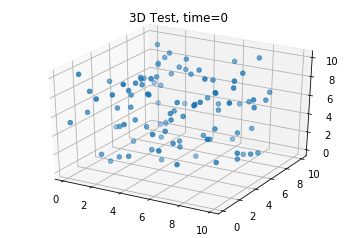

In [7]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation
import pandas as pd


a = np.random.rand(2000, 3)*10
t = np.array([np.ones(100)*i for i in range(20)]).flatten()
df = pd.DataFrame({"time": t ,"x" : a[:,0], "y" : a[:,1], "z" : a[:,2]})

def update_graph(num):
    data=df[df['time']==num]
    graph._offsets3d = (data.x, data.y, data.z)
    title.set_text('3D Test, time={}'.format(num))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
title = ax.set_title('3D Test')

data=df[df['time']==0]
graph = ax.scatter(data.x, data.y, data.z)

ani = matplotlib.animation.FuncAnimation(fig, update_graph, 19, 
                               interval=40, blit=False)


HTML(ani.to_html5_video())